# Declarations

In [1]:
def import_or_install(package):
#     source : 
#     stackoverflow.com/questions/4527554/check-if-module-exists-if-not-install-it
    """
    Input : string package
    Output : install package if it does not exist
    """
    try:
        __import__(package)
    except ImportError:
        pip.main(['install',package])

In [2]:
import pandas as pd
import numpy as np
import json
import pip
import re
from urllib.request import urlopen
import_or_install('wikidata')
import requests
from wikidata.client import Client

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting wikidata

Downloading Wikidata-0.7.0-py3-none-any.whl (29 kB)

Installing collected packages: wikidata

Successfully installed wikidata-0.7.0

## Functions declarations

In [3]:
def load_all_to_df(*datasets):
    """
    Input : strings of CSVs titles
    Output: pandas dataframe containg all records in all CSVs
    """
    df_list = [pd.read_csv(dataset) for dataset in datasets]
    return pd.concat(df_list, ignore_index=True)

In [4]:
def get_wikipedia_url(wikidata):
    """
    Input : string wikidata ID
    Output: wikipedia page url
    """
    client = Client()
    entity = client.get(wikidata, load=True)
    return entity.data['sitelinks']['enwiki']['url']

In [5]:
def get_wikipedia_title(url):
    """
    Input : string wikipedia url
    Output : string wikipedia title
    """
    pattern = r'/'
    words = re.sub(pattern,' ',url).split(' ')
    return words[-1]

In [6]:
def get_json_wikipedia(url):
    baseurl = 'https://en.wikipedia.org/w/api.php?'
    action = 'action=query'
    content = '&prop=revisions&rvprop=content'
    dataformat = '&format=json'
    title = '&titles=' + get_wikipedia_title(url)
    query = "%s%s%s%s%s" % (baseurl,action,content,dataformat,title)
    
    wikiresponse = urlopen(query)
    wikisource = wikiresponse.read()
    
    return json.loads(wikisource)

In [60]:
import pickle
def get_content_wikipedia(member: str, 
    action = 'query',
    name = None,
    prop = 'revisions',
    export = False,
    df = None
    ) -> list:
    """"
    A function that takes in a character title on wikipedia and returns the
    a list with dictionaries containing the title of the characters 
    whose links are referenced in the wikipedia page

    Attributes
    ----------
    character : string
        Character wikilink
    action : string
        The action that you need for the wikipage, default is query.
    name : string
        The name of the character. Will aslo be used as the filename for the pickle file.
    prop : string
        The type of content required from the wikipage. If links is selected then you will get all links from the wikipage.
    Export : bool 
        If set to True the function will export the characters into pickle files to a directory (already set).
    df : pandas dataframe
        If given, will be used to filter all links into a list of characters found in that dataframe.

    Returns
    -------
    wikitext : string
        The text found on a character's wikipedia page.
    """
    url = "https://en.wikipedia.org/w/api.php"
    # prop = 'revisions' <- Has a more html look, can be useful for finding links
    # format = 'json'
    # prop = 'extracts' <- looks good but has not html 
    # prop = 'links' <- returns only the links found on the wikipage
    # pllimit=max
    Params = {
        'action':action,
        'format':'json',
        'prop':prop,
        'titles':get_wikipedia_title(member),
        'rvprop':'content'
    }
    try:
        if prop == 'links':
            Params['pllimit'] = 'max'
            response = requests.get(url=url, params=Params).json()
            page = next(iter(response['query']['pages'].values()))
            title = [name['title'] for name in page['links']]
            if export == True:
                filepath = f'Characters_links/{name}.pkl'.format(name=name)
                pickle.dump(title, open( filepath, "wb" ) )
                print(f'{name}.pkl has been saved succesfully')
                return None
            return title
            # url = 'https://en.wikipedia.org/w/api.php?action={action}&prop={prop}&rvprop=content&format={format}&titles={title}&rvslots=main&explaintext=True'.format(action=action, format=format, title=character, prop=prop)
        elif prop == 'extracts':
            Params['explaintext'] = True
            response = requests.get(url=url, params=Params).json()
            print(member)
            # page = next(iter(response['query']['pages'].values()))
            page = response['query']['pages']#.values()
            key = list(page.keys())[0]
            page = page[key]['extract']
            if export == True:
                if name != None:
                    character = character.replace('|',' ')
                    filepath = f'Characters_texts/{name}.pkl'.format(name=name)
                    pickle.dump(page, open( filepath, "wb" ) )
                    print(f'{name}.pkl has been saved succesfully')
                else:
                    filepath = f'Characters_texts/{character}.pkl'.format(character=character)
                    pickle.dump(page, open( filepath, "wb" ) )
                    print(f'{character}.pkl has been saved succesfully')
                return None
            return page
    except KeyError:
        print('Member not found in wikipedia')

In [54]:
def connection_count(df = None):
    """
    Input : pandas dataframe
    Output : pandas dataframe with a new column containing the number of connections
    """
    df['connections'] = 0
    for wikiId in df.wikidata:
        url = get_wikipedia_url(wikiId)
        member = get_wikipedia_title(url)
        links = get_content_wikipedia(member, prop='links')
        try:
            for i in df.name:
                if i in links:
                    df.loc[df.wikidata == wikiId, 'connections'] += 1
        except TypeError:
            df.loc[df.name == i, 'connections'] = 0
    return df

In [82]:
def connection_links(wikiId) -> list:
    """
    Output : list of all links found in the wikipedia pages of all members
    """
    url = get_wikipedia_url(wikiId)
    member = get_wikipedia_title(url)
    links = get_content_wikipedia(member, prop='links')
    return links

# Load data for all members: senate and congress

In [25]:
df_members = load_all_to_df('term-116_congress.csv','term-116_senate.csv')
member_wikiID = df_members.loc[1,'wikidata']
url = get_wikipedia_url(member_wikiID)
# get_json_wikipedia(url)

## Conection count

We are now going to try to see if we can get the number of connections for a member. This will then be added as a new column to our dataframe. First of all we will see in the example below how the calculation is done.

In [30]:
member = get_wikipedia_title(url) # Name of the politician
cont = get_content_wikipedia(member, prop='extracts') # Full wikipedia article in extract format for better readability
cont_link = get_content_wikipedia(member, prop='links') # Array of links found in politician's wikipedia page.

Drew_Ferguson_(politician)


In [59]:
found = 0
for i in df_members.name: #
    if i in cont_link:
        # print(df_members.loc[df_members.wikidata == member_wikiID].name) # uncomment to see which politician we are getting the connections from
        found += 1
print(found)

192


Now that we know exactly how the code is working we will utilize the `connection_count` function to obtain a new dataframe with the column we are looking for. It is important to note that the function will return a 0 alongside a message if the politician is not found in wikipedia.

In [55]:
df_connections = connection_count(df_members)

Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia
Character not found in wikipedia


In [57]:
df_connections.head()

,id,name,sort_name,email,twitter,facebook,group,group_id,area_id,area,chamber,term,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area,connections
0,eaf0104e-b8ae-4336-a353-ca5228fe2752,A. Donald McEachin,"McEachin, A.",NaN,RepMcEachin,RepMcEachin,Democrat,democrat,VA-4,Virginia's 4th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q4647699,Q29552,Q7934058,0
1,c5441370-42c5-4d83-b73e-6130cc4910cc,A. Drew Ferguson IV,"Ferguson, A.",NaN,RepDrewFerguson,RepDrewFerguson,Republican,republican,GA-3,Georgia's 3rd congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q26157659,Q29468,Q5547263,192
2,05165473-b19d-484d-8de3-e6ed420cc299,Abby Finkenauer,"Finkenauer, Abby",NaN,NaN,NaN,Democrat,democrat,IA-1,Iowa's 1st congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,female,Q24435337,Q29552,Q13858962,4
3,6133038f-b893-45d2-aa09-a7feb433edf7,Abigail Davis Spanberger,"Spanberger, Abigail",NaN,NaN,NaN,Democrat,democrat,VA-7,Virginia's 7th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,female,Q55603085,Q29552,Q7934064,160
4,e0b61cab-a183-4a44-bb0a-81f25fda8de3,Adam B. Schiff,"Schiff, Adam",NaN,RepAdamSchiff,RepAdamSchiff,Democrat,democrat,CA-28,California's 28th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q350843,Q29552,Q5020000,130


We can now see the new column of data in our dataframe. It is now time wee see how it's distributed.

<AxesSubplot:xlabel='connections', ylabel='Count'>

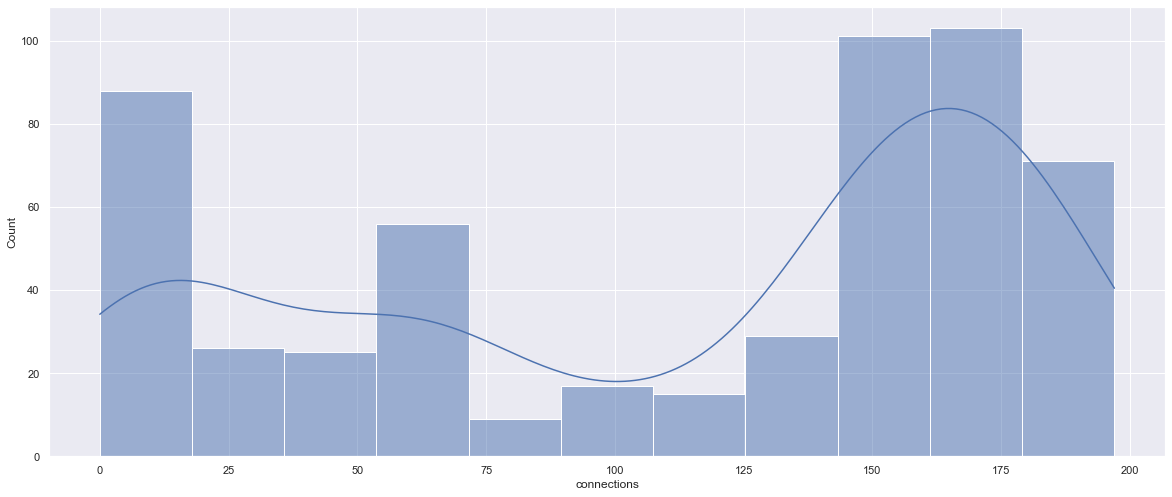

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 2, figsize=(22,8))

sns.set(rc={'figure.figsize':(20,8.27)})
sns.histplot(data=df_connections, x="connections", kde=True)
# plt.xticks(rotation=90)

<AxesSubplot:xlabel='connections', ylabel='name'>

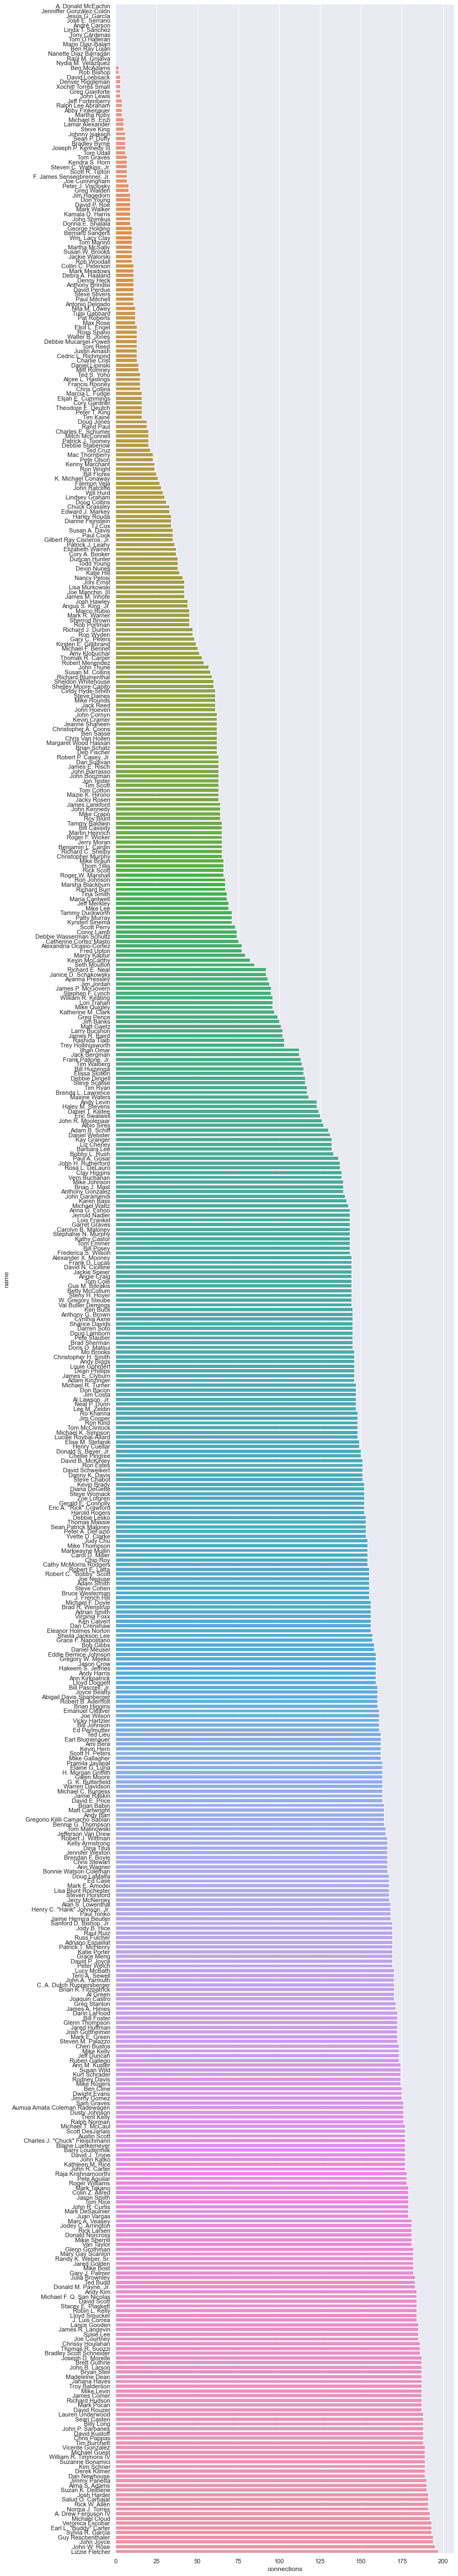

In [81]:
# WARNING big visual below
sns.set(rc={'figure.figsize':(11,85)})
sns.barplot(data=df_connections, y = 'name', x = 'connections', order=df_connections.sort_values('connections').name)
# plt.xticks(rotation=90)

## Graph Creation

In [ ]:
# Thank you Magnus
import networkx as nx

def graphCreator(DG, df):
    # Creating directed network
    for politician in df.names:
        party = df.loc[df.name == politician, 'group']
        DG.add_nodes_from([(politician, {'Party' : party})])
        links = connection_links(df.loc[df.name == politician, 'wikidata'])
        for name in df.names:
            if link+'.txt' in dir_list:
                match = matchPat(path, link+'.txt')
            
                for hero in match:
                    if hero in inv_marvel_dict.keys():
                        DG.add_nodes_from([(inv_marvel_dict[hero], {'Universe' : 'Marvel'})])
                        DG.add_edge(character, inv_marvel_dict[hero])

                    elif hero in inv_dc_dict.keys():
                        DG.add_nodes_from([(inv_dc_dict[hero], {'Universe' : 'DC'})])
                        DG.add_edge(character, inv_dc_dict[hero])

In [ ]:
D = nx.Diagraph()